In [14]:
%matplotlib inline

# Testing and Benchmarking Triton

**IMPORTANT**: since triton compiler is involved, we must restart the kernel after each modification of the optimized.rmsnorm module

In [15]:
import sys
sys.path.append('..')
import torch
from baselines.rmsnorm import RMSNormL3, RMSNormGT1, MyRMSNorm
# Note, since triton compiler is involved, we must restart the kernel after each modification of the 
# optimized.rmsnorm module
from optimized.rmsnorm import RMSNormTriton
from matplotlib import pyplot as plt

## Results for Ground Truth

In [16]:
def printRMSNorm(rmsnorm_class, x : torch.Tensor = None):
    print("--------------------")
    print("RMSNormTriton: x.shape: ", end="")
    print(x.shape)
    
    # Compute the expected output
    rmsnorm_test = rmsnorm_class(dim=3)
    expected_output = rmsnorm_test.forward(x)
    print(x)
    print(expected_output)

printRMSNorm(RMSNormGT1, torch.tensor([[1, 2, 3], [3, 3, 3], [7, 8, 9], [100, 150, 150]], dtype=torch.float32))
printRMSNorm(RMSNormGT1, torch.tensor([[1, 2, 3], ], dtype=torch.float16))
printRMSNorm(RMSNormGT1, torch.tensor([1, 2, 3], dtype=torch.float16))
printRMSNorm(RMSNormGT1, torch.tensor([[[1, 2, 3], [7, 8, 9]], [[100, 150, 150], [100, 150, 150]]], dtype=torch.float16))

--------------------
RMSNormTriton: x.shape: torch.Size([4, 3])
tensor([[  1.,   2.,   3.],
        [  3.,   3.,   3.],
        [  7.,   8.,   9.],
        [100., 150., 150.]])
tensor([[0.4629, 0.9258, 1.3887],
        [1.0000, 1.0000, 1.0000],
        [0.8705, 0.9948, 1.1192],
        [0.7385, 1.1078, 1.1078]], grad_fn=<MulBackward0>)
--------------------
RMSNormTriton: x.shape: torch.Size([1, 3])
tensor([[1., 2., 3.]], dtype=torch.float16)
tensor([[0.4629, 0.9258, 1.3887]], grad_fn=<MulBackward0>)
--------------------
RMSNormTriton: x.shape: torch.Size([3])
tensor([1., 2., 3.], dtype=torch.float16)
tensor([0.4629, 0.9258, 1.3887], grad_fn=<MulBackward0>)
--------------------
RMSNormTriton: x.shape: torch.Size([2, 2, 3])
tensor([[[  1.,   2.,   3.],
         [  7.,   8.,   9.]],

        [[100., 150., 150.],
         [100., 150., 150.]]], dtype=torch.float16)
tensor([[[0.4629, 0.9258, 1.3887],
         [0.8706, 0.9946, 1.1191]],

        [[0.7388, 1.1074, 1.1074],
         [0.7388, 1.

Results for Triton

In [17]:
def printRMSNorm(rmsnorm_class, x : torch.Tensor = None):
    print("--------------------")
    print("RMSNormTriton: x.shape: ", end="")
    print(x.shape)
    # Compute the expected output
    rmsnorm_test = rmsnorm_class(dim=3).cuda()
    expected_output = rmsnorm_test.forward(x.cuda())
    print(x)
    print(expected_output)

# One sequence
printRMSNorm(RMSNormTriton, torch.tensor([[1, 2, 3], ], dtype=torch.float16))

# Multiple sequences
printRMSNorm(RMSNormTriton, torch.tensor([[1, 2, 3], [3, 3, 3], [7, 8, 9], [100, 150, 150]], dtype=torch.float32))

# Multiple batches, with multiple sequences
printRMSNorm(RMSNormTriton, torch.tensor([[[1, 2, 3], [7, 8, 9]], [[100, 150, 150], [100, 150, 150]]], dtype=torch.float16))

--------------------
RMSNormTriton: x.shape: torch.Size([1, 3])
tensor([[1., 2., 3.]], dtype=torch.float16)
tensor([[0.4629, 0.9258, 1.3887]], device='cuda:0', grad_fn=<MulBackward0>)
--------------------
RMSNormTriton: x.shape: torch.Size([4, 3])
tensor([[  1.,   2.,   3.],
        [  3.,   3.,   3.],
        [  7.,   8.,   9.],
        [100., 150., 150.]])
tensor([[0.4629, 0.9258, 1.3887],
        [1.0000, 1.0000, 1.0000],
        [0.8705, 0.9948, 1.1192],
        [0.7385, 1.1078, 1.1078]], device='cuda:0', grad_fn=<MulBackward0>)
--------------------
RMSNormTriton: x.shape: torch.Size([2, 2, 3])
tensor([[[  1.,   2.,   3.],
         [  7.,   8.,   9.]],

        [[100., 150., 150.],
         [100., 150., 150.]]], dtype=torch.float16)
tensor([[[0.4629, 0.9258, 1.3887],
         [0.8706, 0.9946, 1.1191]],

        [[0.7388, 1.1074, 1.1074],
         [0.7388, 1.1074, 1.1074]]], device='cuda:0', grad_fn=<MulBackward0>)


In [18]:
print("RMSNormTriton: x.shape: ", end="")

RMSNormTriton: x.shape: 

# Actual Performance Measurment

## Verify that outputs match

In [19]:
import triton

# Make sure the numbers are the same (or close)
torch.manual_seed(0)
seq_len = 100
model_dim = 4096
x = torch.randn(seq_len, model_dim, device='cuda')

# Triton implementation
rmsnormtriton = RMSNormTriton(dim=model_dim).cuda()
triton_output = rmsnormtriton.forward(x)

# Ground Truth PyTorch implementation
rmsnormgt1 = RMSNormGT1(dim=model_dim).cuda()
torch_output = rmsnormgt1.forward(x)
if torch.allclose(triton_output, torch_output):
# assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


## Measure Runtime

In [20]:
# Values of sequence leng to Sweep
x_vals = [1, 128, 256] + [512 * i for i in range(1, 25)]

# Value of model_dim
model_dim = model_dim # from cell above since we pre-allocate the "model"

runtime:
     SeqLen    Triton  Torch (native)  Torch (compiled)
0       1.0  0.188832        0.030688          0.451280
1     128.0  0.195872        0.048608          0.489824
2     256.0  0.196416        0.076736          0.489728
3     512.0  0.194512        0.137968          0.487952
4    1024.0  0.238944        0.238848          0.486304
5    1536.0  0.341024        0.340704          0.486768
6    2048.0  0.444160        0.443520          0.488096
7    2560.0  0.547168        0.546464          0.487776
8    3072.0  0.649920        0.648960          0.489824
9    3584.0  0.751600        0.751232          0.508160
10   4096.0  0.854816        0.854048          0.494048
11   4608.0  0.957952        0.957456          0.509760
12   5120.0  1.060256        1.059472          0.507968
13   5632.0  1.174720        1.174288          0.506656
14   6144.0  1.273120        1.272384          0.507840
15   6656.0  1.371760        1.371328          0.505696
16   7168.0  1.471952        1.471984  

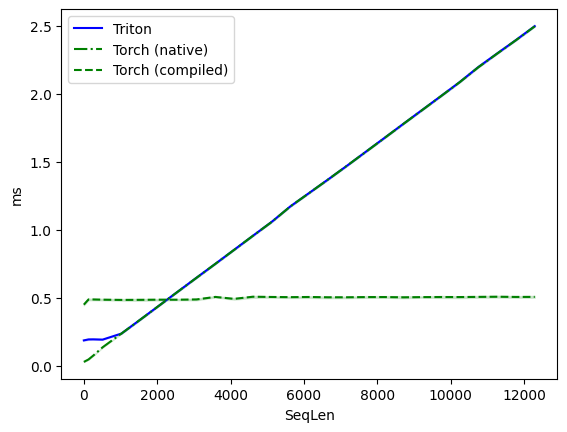

In [21]:
plot_name = 'runtime'

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['SeqLen'],  # argument names to use as an x-axis for the plot
        # I want to benchmark sequence lengths from 1 to 12,800 
        # llama2 context size is 8k tokens, but longer context len extensions are possible
        # also I observed that it is the only way to saturate GPU memory BW of V100
        # I want to include 1,128,and 256 to see the effect of small sequence lengths
        x_vals = x_vals,

        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-compile'
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (compiled)"
        ],  # label name for the lines

        styles=[('blue', '-'), ('green', '-.'), ('green', '--')],  # line styles
        # ylabel="GB/s",  # label name for the y-axis
        ylabel="ms",  # label name for the y-axis
        plot_name=plot_name,  # name for the plot. Used also as a file name for saving the plot.
        args={'N': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))

def benchmark(SeqLen, N, provider):
    x = torch.randn(SeqLen, N, device='cuda', dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8] # report median, 20th and 80th percentiles
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: rmsnormtriton(x), quantiles=quantiles)
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: rmsnormgt1(x), quantiles=quantiles)
    if provider == 'torch-compile':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.compile(rmsnormgt1)(x), quantiles=quantiles)

    # For GB/s reports
    # gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    # return gbps(ms), gbps(max_ms), gbps(min_ms)

    # For ms reports
    return ms, max_ms, min_ms


benchmark.run(show_plots=False, print_data=True, save_path='./prof/')
plt.show()

## Memory Bandwidth

In [22]:
plot_name = 'bandwidth'

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['SeqLen'],  # argument names to use as an x-axis for the plot
        # I want to benchmark sequence lengths from 1 to 12,800 
        # llama2 context size is 8k tokens, but longer context len extensions are possible
        # also I observed that it is the only way to saturate GPU memory BW of V100
        # I want to include 1,128,and 256 to see the effect of small sequence lengths
        x_vals = x_vals,

        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-compile'
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (compiled)"
        ],  # label name for the lines

        styles=[('blue', '-'), ('green', '-.'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="bandwidth",  # name for the plot. Used also as a file name for saving the plot.
        # ylabel="ms",  # label name for the y-axis
        # plot_name="runtime",  # name for the plot. Used also as a file name for saving the plot.
        args={'N': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))

def benchmark(SeqLen, N, provider):
    x = torch.randn(SeqLen, N, device='cuda', dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8] # report median, 20th and 80th percentiles
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: rmsnormtriton(x), quantiles=quantiles)
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: rmsnormgt1(x), quantiles=quantiles)
    if provider == 'torch-compile':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.compile(rmsnormgt1)(x), quantiles=quantiles)

    # For GB/s reports
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

    # For ms reports
    # return ms, max_ms, min_ms


benchmark.run(show_plots=False, print_data=True, save_path='./prof/')
plt.show()

## Torch Profiler

In [ ]:

seq_len = 4096
model_dim = 4096

def runRMSNorm(rmsnorm_class, x : torch.Tensor = None):
    rmsnorm_test = rmsnorm_class(dim=model_dim).cuda()
    rmsnorm_test.forward(x.cuda())

# In this example with wait=1, warmup=1, active=2, repeat=1,
# profiler will skip the first step/iteration,
# start warming up on the second, record
# the third and the forth iterations,
# after which the trace will become available
# and on_trace_ready (when set) is called;
# the cycle repeats starting with the next step
wait_val = 1
warmup_val = 1
active_val = 2
repeat_val = 1

def trace_handler(prof):
    """trace_handler is called every time a new trace becomes available"""

    print(prof.key_averages().table(
        sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("prof/rmsnorm_trace_{}x{}_{}.json".format(
        seq_len, model_dim, prof.step_num))

with torch.profiler.profile(
    activities=[
        # torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],

    schedule=torch.profiler.schedule(wait=wait_val, 
                                     warmup=warmup_val, 
                                     active=active_val, 
                                     repeat=repeat_val),
    on_trace_ready=trace_handler
    # Outputting for tensorboard? Use this instead:
    # on_trace_ready=torch.profiler.tensorboard_trace_handler('./prof')
    ) as p:
        for iter in range(10):
            x = torch.randn(seq_len, model_dim, device='cuda', dtype=torch.float16)
            runRMSNorm(RMSNormTriton, x)
            p.step()


In [ ]:
import re
def get_cuda_time_in_ms(the_table_str: str):
    for line in the_table_str.splitlines():
        if "Self CUDA time total:" in line:
            match = re.search(r"(\d+\.\d+)(\w+)", line)
            if match:
                time_value = float(match.group(1))
                unit = match.group(2)
                if unit == 'us':  # if unit is microseconds, convert to milliseconds
                    time_value /= 1000
                return time_value

# Use the function
cuda_time_in_ms = get_cuda_time_in_ms(p.key_averages().table(sort_by="self_cuda_time_total", row_limit=1))
print(cuda_time_in_ms)

In [ ]:
import mlflow

experiment_name = "rmsnorm"
implementation_name = "RMSNormTriton"
implementation_type = "triton"

if(True):
    # List of files to log
    files_to_log = ['../optimized/rmsnorm.py', 
                    'prof/bandwidth.csv', 
                    'prof/bandwidth.png', 
                    'prof/runtime.csv', 
                    'prof/runtime.png',
                    'prof/rmsnorm_trace_4096x4096_4.json'
                    ]

    # Start an MLflow run
    with mlflow.start_run():
        # Iterate over the list of files
        for file in files_to_log:
            # Log each file as an artifact
            mlflow.log_artifact(file)
        
        # Log experiment with seq_len and model_dim, and result cuda_time_in_ms
        mlflow.log_param("seq_len", seq_len)
        mlflow.log_param("model_dim", model_dim)
        mlflow.log_param("implementation", implementation_name)
        mlflow.log_metric("cuda_time_in_ms", cuda_time_in_ms)